In [1]:
import db_conn
import pandas as pd
import numpy as np
import copy
import collections
import statsmodels.formula.api as sm
import scipy.stats as st
import matplotlib.pyplot  as plt
from IPython.display import display
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as sklearnPCA
import seaborn as sns

In [2]:
plt.style.use('dark_background')
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
sql = """SELECT * FROM score_line"""
score_line = db_conn.select_query(sql)
score_line_pd = pd.DataFrame(score_line, columns=['match_id', 'season_year', 'division', 'id', 'half_type', 'play_time', 'time_range', 'home_score', 'away_score', 'home_team_id', 'away_team_id', 'score_team_id', 'winning_team', 'score_player'])
score_line_pd = score_line_pd[score_line_pd.id > 0]
score_line_pd.head()

,match_id,season_year,division,id,half_type,play_time,time_range,home_score,away_score,home_team_id,away_team_id,score_team_id,winning_team,score_player
1,2013-1-001,2013,1,2,1,29,2,1,0,10,25,10,0,1
2,2013-1-001,2013,1,3,1,32,3,1,1,10,25,25,0,2
3,2013-1-001,2013,1,4,2,2,4,2,1,10,25,10,0,3
5,2013-1-001,2013,1,5,2,38,6,2,2,10,25,25,0,4
7,2013-1-002,2013,1,6,1,4,1,0,1,19,5,5,19,5


In [4]:
score_line_w_goal_type = pd.DataFrame(score_line_pd, columns=score_line_pd.columns.append(pd.Index(['g_fg', 'g_tg', 'g_lg', 'g_cg', 'l_fg', 'l_tg', 'l_lg', 'l_cg'])))
score_line_w_goal_type = score_line_w_goal_type.fillna(False)

score_line_w_goal_type.g_fg = (score_line_w_goal_type.home_score + score_line_w_goal_type.away_score == 1) & (score_line_w_goal_type.score_team_id == score_line_w_goal_type.home_team_id)
score_line_w_goal_type.l_fg = (score_line_w_goal_type.home_score + score_line_w_goal_type.away_score == 1) & (score_line_w_goal_type.score_team_id == score_line_w_goal_type.away_team_id)

score_line_w_goal_type.g_tg = (score_line_w_goal_type.home_score == score_line_w_goal_type.away_score) & (score_line_w_goal_type.home_score + score_line_w_goal_type.away_score > 0) & (score_line_w_goal_type.score_team_id == score_line_w_goal_type.home_team_id)
score_line_w_goal_type.l_tg = (score_line_w_goal_type.home_score == score_line_w_goal_type.away_score) & (score_line_w_goal_type.home_score + score_line_w_goal_type.away_score > 0) & (score_line_w_goal_type.score_team_id == score_line_w_goal_type.away_team_id)

score_line_w_goal_type.g_lg = (score_line_w_goal_type.home_score > score_line_w_goal_type.away_score) & (score_line_w_goal_type.home_score + score_line_w_goal_type.away_score > 1) & (score_line_w_goal_type.score_team_id == score_line_w_goal_type.home_team_id)
score_line_w_goal_type.l_cg = (score_line_w_goal_type.home_score > score_line_w_goal_type.away_score) & (score_line_w_goal_type.home_score + score_line_w_goal_type.away_score > 1) & (score_line_w_goal_type.score_team_id == score_line_w_goal_type.away_team_id)

score_line_w_goal_type.g_cg = (score_line_w_goal_type.home_score < score_line_w_goal_type.away_score) & (score_line_w_goal_type.home_score + score_line_w_goal_type.away_score > 1) & (score_line_w_goal_type.score_team_id == score_line_w_goal_type.home_team_id)
score_line_w_goal_type.l_lg = (score_line_w_goal_type.home_score < score_line_w_goal_type.away_score) & (score_line_w_goal_type.home_score + score_line_w_goal_type.away_score > 1) & (score_line_w_goal_type.score_team_id == score_line_w_goal_type.away_team_id)

score_line_w_goal_type.winning_flag = np.where(score_line_w_goal_type.winning_team == 0, 0, np.where(score_line_w_goal_type.home_team_id == score_line_w_goal_type.winning_team, 1, -1))

score_line_w_goal_type.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  app.launch_new_instance()


,match_id,season_year,division,id,half_type,play_time,time_range,home_score,away_score,home_team_id,away_team_id,score_team_id,winning_team,score_player,g_fg,g_tg,g_lg,g_cg,l_fg,l_tg,l_lg,l_cg
1,2013-1-001,2013,1,2,1,29,2,1,0,10,25,10,0,1,True,False,False,False,False,False,False,False
2,2013-1-001,2013,1,3,1,32,3,1,1,10,25,25,0,2,False,False,False,False,False,True,False,False
3,2013-1-001,2013,1,4,2,2,4,2,1,10,25,10,0,3,False,False,True,False,False,False,False,False
5,2013-1-001,2013,1,5,2,38,6,2,2,10,25,25,0,4,False,False,False,False,False,True,False,False
7,2013-1-002,2013,1,6,1,4,1,0,1,19,5,5,19,5,False,False,False,False,True,False,False,False


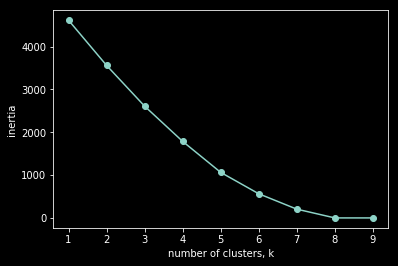

In [5]:
ks = range(1,10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(score_line_w_goal_type[['g_fg', 'g_tg', 'g_lg', 'g_cg', 'l_fg', 'l_tg', 'l_lg', 'l_cg']])
    inertias.append(model.inertia_)
  
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [6]:
model = KMeans(n_clusters=6, init="random", n_init=1, max_iter=1, random_state=1).fit(score_line_w_goal_type[['g_fg', 'g_tg', 'g_lg', 'g_cg', 'l_fg', 'l_tg', 'l_lg', 'l_cg']])

In [7]:
model.labels_, model.cluster_centers_

(array([1, 0, 0, ..., 0, 2, 2], dtype=int32),
 array([[ 1.42386103e-14,  1.54849688e-01,  3.19909246e-01,
          5.33182076e-02,  1.07691633e-14,  1.60805445e-01,
          2.47589336e-01,  6.35280771e-02],
        [ 1.00000000e+00,  1.55431223e-15, -4.30211422e-15,
         -2.42861287e-16,  3.24740235e-15,  1.41553436e-15,
         -1.80411242e-15,  1.31838984e-16],
        [-1.74860126e-15,  9.43689571e-16, -3.99680289e-15,
          1.11022302e-16,  1.00000000e+00,  9.15933995e-16,
         -1.49880108e-15,  1.31838984e-16],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00

In [8]:
cluster_goal_pd = pd.DataFrame(score_line_w_goal_type, columns=['match_id', 'season_year', 'division', 'id', 'cluster_group', 'cluster_label', 'score_player', 'g_fg', 'g_tg', 'g_lg', 'g_cg', 'l_fg', 'l_tg', 'l_lg', 'l_cg'])
cluster_goal_pd.cluster_group = model.labels_

In [9]:
cluster_goal_pd[['g_fg', 'g_tg', 'g_lg', 'g_cg', 'l_fg', 'l_tg', 'l_lg', 'l_cg']] = cluster_goal_pd[['g_fg', 'g_tg', 'g_lg', 'g_cg', 'l_fg', 'l_tg', 'l_lg', 'l_cg']].astype('int64')

# for g in range(0, 5):
#     display(cluster_goal_pd[cluster_goal_pd.cluster_group == g].describe())

In [10]:
match_by_goal_pd = score_line_w_goal_type.groupby('match_id').agg({'season_year': 'max', 'division': 'max', 'winning_team': 'max', 'home_team_id': 'max', 'away_team_id': 'max', 'g_fg': 'sum', 'g_tg': 'sum', 'g_lg': 'sum', 'g_cg': 'sum', 'l_fg': 'sum', 'l_tg': 'sum', 'l_lg': 'sum', 'l_cg': 'sum'}).reset_index()
match_by_goal_pd[['g_fg', 'g_tg', 'g_lg', 'g_cg', 'l_fg', 'l_tg', 'l_lg', 'l_cg']] = match_by_goal_pd[['g_fg', 'g_tg', 'g_lg', 'g_cg', 'l_fg', 'l_tg', 'l_lg', 'l_cg']].astype('int64')
match_by_goal_pd.head()

,match_id,season_year,division,winning_team,home_team_id,away_team_id,g_fg,g_tg,g_lg,g_cg,l_fg,l_tg,l_lg,l_cg
0,2013-1-001,2013,1,0,10,25,1,0,1,0,0,2,0,0
1,2013-1-002,2013,1,19,19,5,0,1,1,0,1,0,0,0
2,2013-1-003,2013,1,23,21,23,0,0,0,0,1,0,0,0
3,2013-1-004,2013,1,13,12,13,0,1,0,0,1,0,1,0
4,2013-1-006,2013,1,0,7,1,1,0,1,0,0,1,0,1


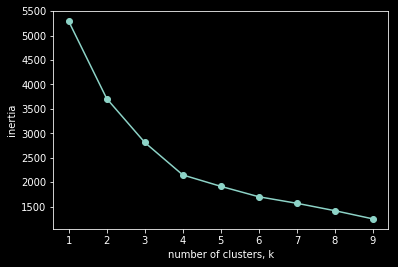

In [11]:
ks = range(1,10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(match_by_goal_pd[['g_fg', 'g_tg', 'g_lg', 'g_cg', 'l_fg', 'l_tg', 'l_lg', 'l_cg']])
    inertias.append(model.inertia_)
  
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [12]:
model = KMeans(n_clusters=3, init="random", n_init=1, max_iter=1, random_state=1)
model = model.fit(match_by_goal_pd[['g_fg', 'g_tg', 'g_lg', 'g_cg', 'l_fg', 'l_tg', 'l_lg', 'l_cg']])
model

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=1, n_clusters=3,
    n_init=1, n_jobs=1, precompute_distances='auto', random_state=1,
    tol=0.0001, verbose=0)

In [13]:
model.labels_, model.cluster_centers_

(array([0, 0, 0, ..., 2, 0, 0], dtype=int32),
 array([[ 5.65505804e-01,  2.23051410e-01,  2.75290216e-01,
         -1.47104551e-15,  4.34494196e-01,  3.15920398e-01,
          1.83250415e-01,  2.52575738e-15],
        [ 9.11528150e-02,  6.35388740e-01,  1.04557641e-01,
          5.04021448e-01,  9.08847185e-01,  1.47453083e-01,
          1.70777480e+00,  2.68096515e-03],
        [ 8.92957746e-01,  1.12676056e-01,  2.13239437e+00,
         -1.24900090e-16,  1.07042254e-01,  3.69014085e-01,
          4.22535211e-02,  6.28169014e-01]]))

In [14]:
cluster_match_by_goal_pd = pd.DataFrame(match_by_goal_pd, columns=['match_id', 'season_year', 'division', 'winning_flag', 'winning_team', 'home_team_id', 'away_team_id', 'cluster_group', 'g_fg', 'g_tg', 'g_lg', 'g_cg', 'l_fg', 'l_tg', 'l_lg', 'l_cg'])
cluster_match_by_goal_pd.cluster_group = model.labels_
cluster_match_by_goal_pd.winning_flag = np.where(cluster_match_by_goal_pd.winning_team == cluster_match_by_goal_pd.home_team_id, 1, -1)
cluster_match_by_goal_pd.winning_flag = np.where(cluster_match_by_goal_pd.winning_team == 0, 0, cluster_match_by_goal_pd.winning_flag)
cluster_match_by_goal_pd.head()

,match_id,season_year,division,winning_flag,winning_team,home_team_id,away_team_id,cluster_group,g_fg,g_tg,g_lg,g_cg,l_fg,l_tg,l_lg,l_cg
0,2013-1-001,2013,1,0,0,10,25,0,1,0,1,0,0,2,0,0
1,2013-1-002,2013,1,1,19,19,5,0,0,1,1,0,1,0,0,0
2,2013-1-003,2013,1,-1,23,21,23,0,0,0,0,0,1,0,0,0
3,2013-1-004,2013,1,-1,13,12,13,1,0,1,0,0,1,0,1,0
4,2013-1-006,2013,1,0,0,7,1,2,1,0,1,0,0,1,0,1


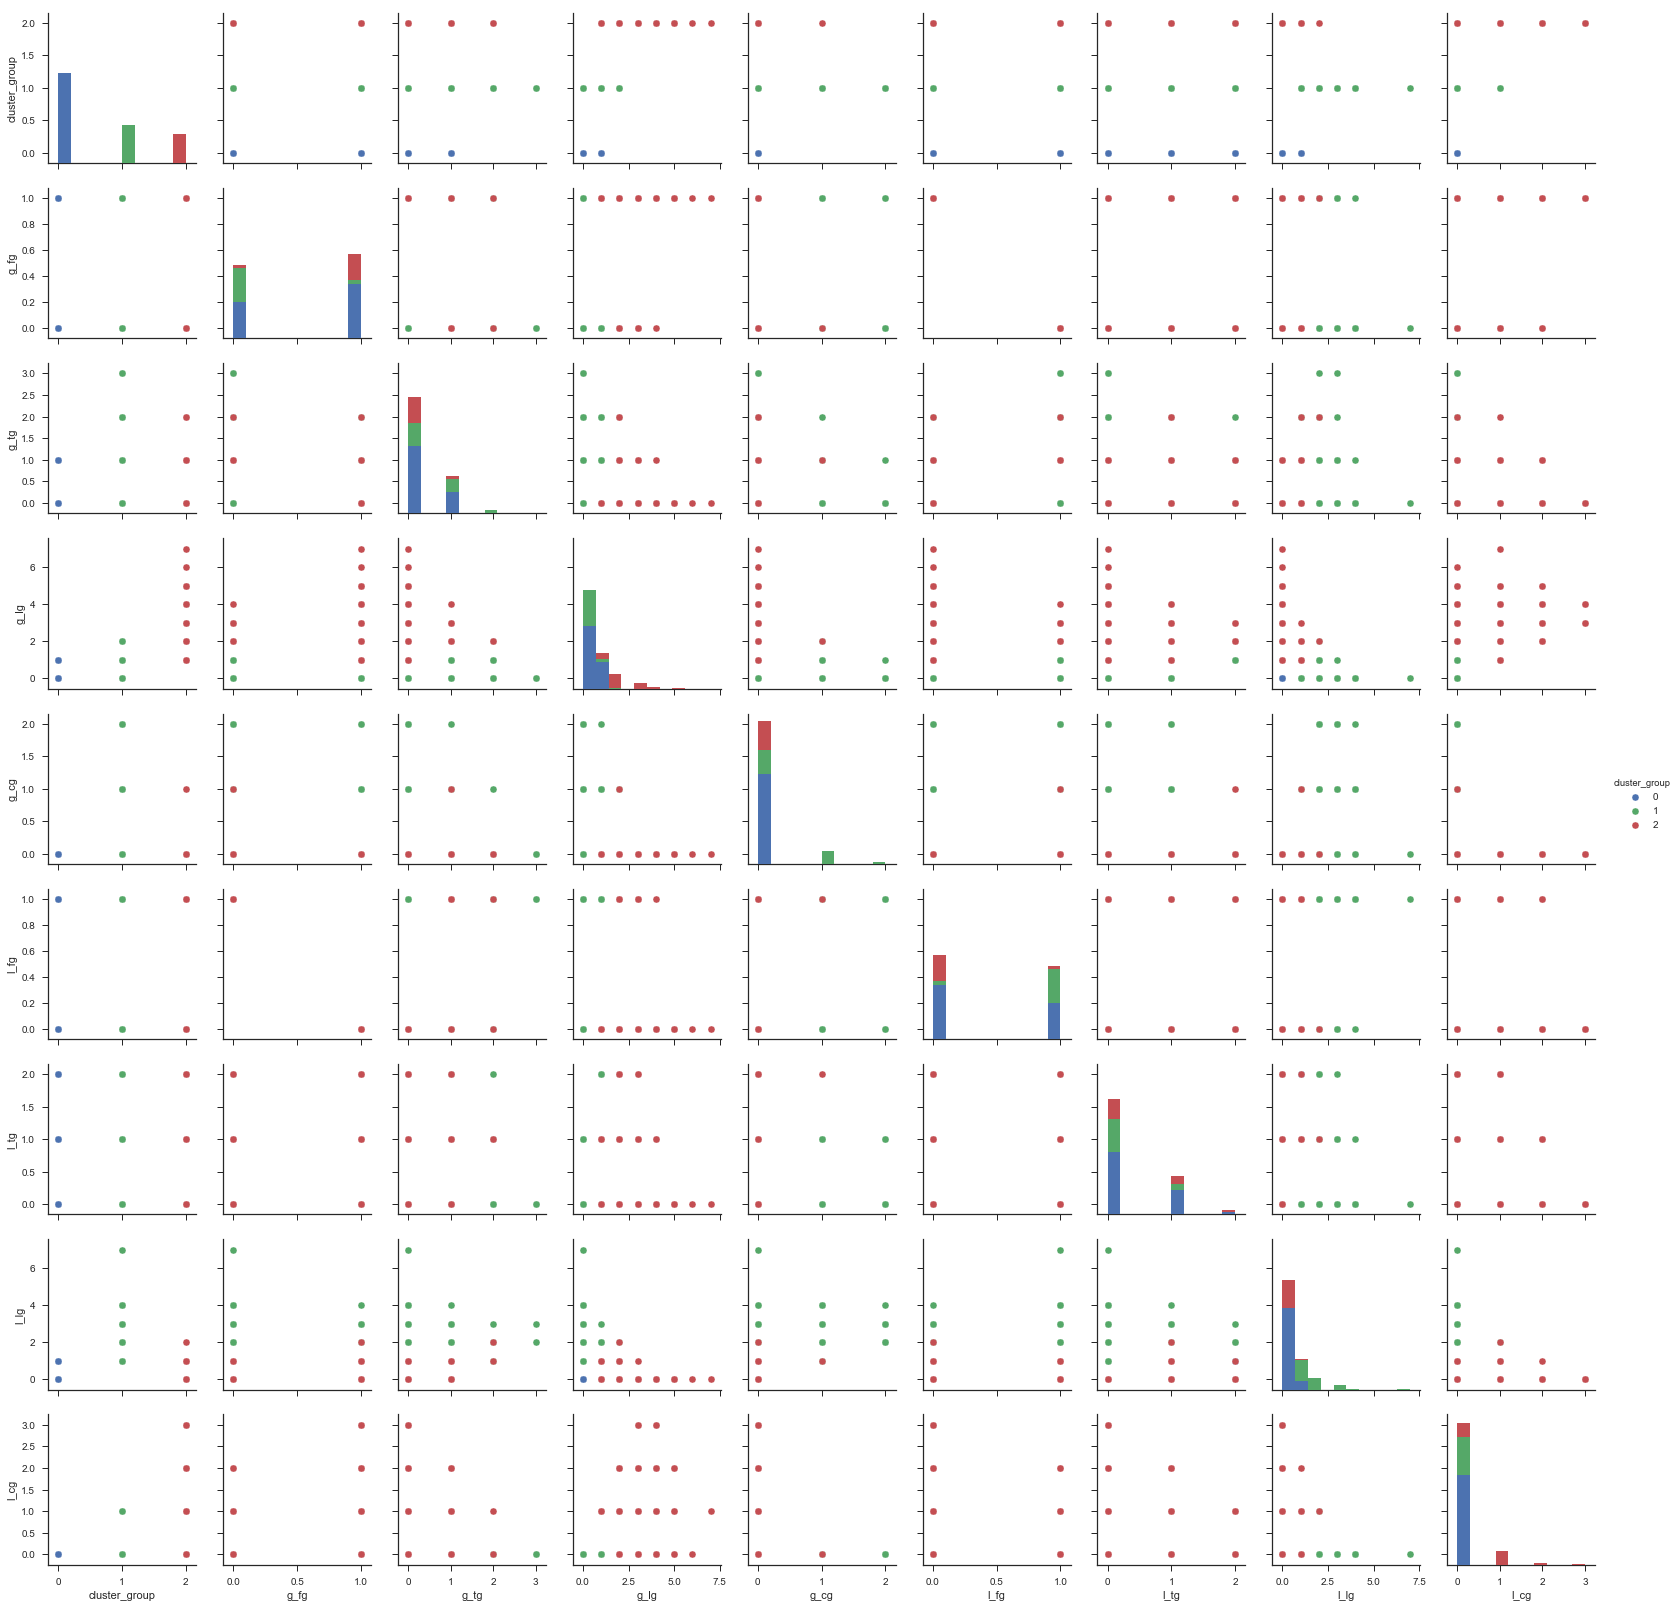

In [15]:
sns.set(style="ticks")

sns.pairplot(cluster_match_by_goal_pd[['cluster_group', 'g_fg', 'g_tg', 'g_lg', 'g_cg', 'l_fg', 'l_tg', 'l_lg', 'l_cg']], hue="cluster_group")

In [16]:
cluster_match_by_goal_pd.head()

,match_id,season_year,division,winning_flag,winning_team,home_team_id,away_team_id,cluster_group,g_fg,g_tg,g_lg,g_cg,l_fg,l_tg,l_lg,l_cg
0,2013-1-001,2013,1,0,0,10,25,0,1,0,1,0,0,2,0,0
1,2013-1-002,2013,1,1,19,19,5,0,0,1,1,0,1,0,0,0
2,2013-1-003,2013,1,-1,23,21,23,0,0,0,0,0,1,0,0,0
3,2013-1-004,2013,1,-1,13,12,13,1,0,1,0,0,1,0,1,0
4,2013-1-006,2013,1,0,0,7,1,2,1,0,1,0,0,1,0,1


In [17]:
for g in range(0, 3):
    display(cluster_match_by_goal_pd[cluster_match_by_goal_pd.cluster_group == g].describe())

,season_year,division,winning_flag,winning_team,home_team_id,away_team_id,cluster_group,g_fg,g_tg,g_lg,g_cg,l_fg,l_tg,l_lg,l_cg
count,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.000000,1105.0,1105.000000,1105.000000,1105.000000,1105.0,1105.000000,1105.000000,1105.000000,1105.0
mean,2015.011765,1.444344,0.209955,9.129412,12.571041,12.736652,0.0,0.601810,0.243439,0.299548,0.0,0.398190,0.328507,0.093213,0.0
std,1.380784,0.507933,0.813880,8.568484,7.479723,7.365605,0.0,0.489747,0.429352,0.458267,0.0,0.489747,0.522806,0.290862,0.0
min,2013.000000,1.000000,-1.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
25%,2014.000000,1.000000,0.000000,0.000000,6.000000,6.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
50%,2015.000000,1.000000,0.000000,7.000000,12.000000,12.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
75%,2016.000000,2.000000,1.000000,17.000000,20.000000,20.000000,0.0,1.000000,0.000000,1.000000,0.0,1.000000,1.000000,0.000000,0.0
max,2017.000000,3.000000,1.000000,25.000000,25.000000,25.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,2.000000,1.000000,0.0


,season_year,division,winning_flag,winning_team,home_team_id,away_team_id,cluster_group,g_fg,g_tg,g_lg,g_cg,l_fg,l_tg,l_lg,l_cg
count,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.0,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000
mean,2015.035941,1.494715,-0.852008,11.902748,12.570825,12.974630,1.0,0.109937,0.490486,0.076110,0.395349,0.890063,0.150106,1.596195,0.004228
std,1.424951,0.504717,0.425960,7.880937,7.478200,7.245644,0.0,0.313142,0.660969,0.288406,0.558201,0.313142,0.380517,0.797072,0.064957
min,2013.000000,1.000000,-1.000000,0.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2014.000000,1.000000,-1.000000,5.000000,6.000000,7.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,2015.000000,1.000000,-1.000000,11.000000,12.000000,13.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,2016.000000,2.000000,-1.000000,19.000000,19.000000,19.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000,0.000000
max,2017.000000,3.000000,1.000000,25.000000,25.000000,25.000000,1.0,1.000000,3.000000,2.000000,2.000000,1.000000,2.000000,7.000000,1.000000


,season_year,division,winning_flag,winning_team,home_team_id,away_team_id,cluster_group,g_fg,g_tg,g_lg,g_cg,l_fg,l_tg,l_lg,l_cg
count,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.0,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000,356.000000
mean,2015.014045,1.443820,0.845506,12.252809,13.522472,12.410112,2.0,0.887640,0.126404,2.137640,0.002809,0.112360,0.373596,0.042135,0.623596
std,1.436868,0.508731,0.426261,8.304631,7.547189,7.696373,0.0,0.316253,0.349292,0.925774,0.053000,0.316253,0.564967,0.214725,0.657699
min,2013.000000,1.000000,-1.000000,0.000000,1.000000,1.000000,2.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.000000,1.000000,1.000000,5.000000,7.000000,6.000000,2.0,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,1.000000,1.000000,12.000000,13.000000,11.500000,2.0,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2016.000000,2.000000,1.000000,21.000000,21.000000,19.250000,2.0,1.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,2017.000000,3.000000,1.000000,25.000000,25.000000,25.000000,2.0,1.000000,2.000000,7.000000,1.000000,1.000000,2.000000,2.000000,3.000000


### 결론
* 현재 가지고 있는 변수들만으로는 Clustering으로 의미 있는 구분하기는 어려워보임
* 추후 경기별 지표(슈팅, 유효슈팅, 파울 등등) 수집이 완료된 이후에 재시도할 가치는 있음